# This notebook tries to improve an existing classification model using yolo to crop the image before predicting the class


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremynadal33/classify_stanford_dogs/blob/master/optimize_classification_with_yolo.ipynb)

This notebook presents :
* Downloading and study of the average size of a dog in the Stanford dataset
* Processing of yolo outputs
* Make a function that manage a photo to optimize the predicton

## Connect to google drive, import important data and clone github repo to get access to yolo funcitons

In [62]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  root_dir = '/content/gdrive/My Drive/Formation-OC/P6-Images/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'
  model_dir = root_dir +'models/'

  #my script
  !ls gdrive/MyDrive/Formation-OC/P6-Images/
else:
  print('Not running on CoLab')
  #my script
  root_dir = '/Users/jeremynadal/Documents/Formation OC IML/P6/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'
  model_dir = root_dir +'models/'

Running on CoLab
Mounted at /content/gdrive
inputs					 models		       pngs
metadata_writer_for_image_classifier.py  P6-presentation.pptx


In [54]:
import os
import re
from bs4 import BeautifulSoup
import numpy as np
!git clone https://github.com/Jeremynadal33/classify_stanford_dogs.git
!python /content/classify_stanford_dogs/yolo_functions.py

fatal: destination path 'classify_stanford_dogs' already exists and is not an empty directory.
2021-03-08 16:05:46.164979: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [74]:
if os.path.exists('/content/classify_stanford_dogs/yolo_functions'):
  %run yolo_functions.py
  print('yolo_functions loaded')
else:
  print('WARNING : please download or clone this gituhub repo : https://github.com/Jeremynadal33/classify_stanford_dogs.git')

/content/classify_stanford_dogs


## Download annotations from [Stanford](http://vision.stanford.edu/aditya86/ImageNetDogs/) 

In [8]:
def download_from_url(url, target_path = 'inputs/', keep_download = True, overwrite_download = False):
  import os
  import tarfile
  import requests
  '''Download file or data from url. 
  url (string): path to dataset
  target_path (string, optional): directory path to write download data. Default is inputs/
  keep_download (boolean, optional): wether to keep the the download file after extraction. Default is True
  overwrite_download (boolean, optional): wether to overwrite the file if it exists. Default is False.'''

  assert url != '' and url != None, 'Please, enter correct url'
  
  filename = os.path.basename(url)
  file_location = target_path + filename

  os.makedirs(target_path, exist_ok=True)
 
  if os.path.exists(file_location) and not overwrite_download:
    print("File already exists at {}. Use: 'overwrite_download=True' to overwrite download".format(file_location))
    tarf = tarfile.open(file_location, 'r')
    tarf.extractall(target_path)
    tarf.close()
		
    return
  print('Downloading file from {} to {}.'.format(url,file_location))
	# Download
  with open(file_location, 'wb') as f:
    with requests.get(url, allow_redirects=True, stream=True) as resp:
      for chunk in resp.iter_content(chunk_size = 512):  #chunk_size in bytes
        if chunk:
          f.write(chunk)

  print("Finished downloading.")
  print("Extracting the file now ...")
  tarf = tarfile.open(file_location, 'r')
  tarf.extractall(target_path)
  tarf.close()
  
  if not keep_download:
    os.remove(file_location)


  return '1'

url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar'
download_from_url(url, input_dir, keep_download=False)

Finished downloading.
Extracting the file now ...


'1'

## Checking that everything is ready and extracting bounded boxes from file before getting the average size 

In [113]:
annotation_dir = input_dir + 'Annotation/'
path = annotation_dir + os.listdir(annotation_dir)[0] + '/' + os.listdir(annotation_dir + os.listdir(annotation_dir)[0])[0]
os.path.exists(path)

True

In [127]:
def extract_info(annotation_path, info='bndbox'):
  assert os.path.exists(annotation_path), 'File {} doesnot exist'.format(annotation_path)

  file = open(annotation_path, 'r')
  text = file.read()
  soup = BeautifulSoup(text,'lxml')

  if info == 'bndbox': 
    return int(soup.annotation.bndbox.xmin.text), int(soup.annotation.bndbox.ymin.text), int(soup.annotation.bndbox.xmax.text), int(soup.annotation.bndbox.ymax.text)
  if info == 'specie':
    return soup.find('name').text


extract_info(path, info= 'specie')

'Chihuahua'

In [59]:
num_max = 1000
num = 0

heights = []
widths = []
while num < num_max:
  for fold in os.listdir(annotation_dir):
    for file in os.listdir(annotation_dir+'/'+fold):
      x1, y1, x2, y2 = extract_info(annotation_dir + '/' + fold + '/' + file)
      heights.append(y2-y1)
      widths.append(x2-x1)
      num += 1


In [60]:
print('Over {} images, the average bounded box for dogs in the Stanford dataset is ({},{})'.format(num_max, round(np.mean(widths)), round(np.mean(heights))))


Over 1000 images, the average bounded box for dogs in the Stanford dataset is (289,298)


## Importing and preparing important information for yolo model

In [81]:
model_path = model_dir + 'yolov3_model.h5'

if os.path.exists(model_path):
    print('model exists, loading')
    model = load_model(model_path)
else:
    print('model doesnt exists, creating')
    # define the model
    model = make_yolov3_model()
    # load the model weights
    weight_reader = WeightReader(model_dir+'yolov3.weights')
    # set the model weights into the model
    weight_reader.load_weights(model)
    # save the model to file
    model.save(model_dir+'yolov3_model.h5')

model doesnt exists, creating
loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
load

In [222]:
#yolov3 class names
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# anchors are the predefine sizes of the bounded boxes for yolov3
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

#input_dims for yolo model
input_w, input_h = 416, 416

# define the probability threshold for detected objects
class_threshold = 0.3

## Using yolo model on test img and comparing it with dog boxes

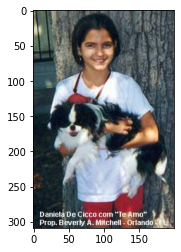

In [219]:
specie_nb = 1
img_nb = 5
species = os.listdir(input_dir+'sep_images/train')

img = input_dir+'sep_images/train/' + species[specie_nb]+'/'+os.listdir(input_dir+'sep_images/train/'+species[specie_nb])[img_nb]
annotation = annotation_dir + species[specie_nb] + '/' + os.listdir(annotation_dir + species[specie_nb])[img_nb]
plt.imshow(plt.imread(img))

In [220]:
# load and prepare image
image, image_w, image_h = load_image_pixels(img, (input_w, input_h))
# make prediction
yhat = model.predict(image)

dog 58.46817493438721


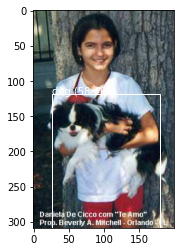

In [221]:
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(img, v_boxes, v_labels, v_scores)


In [215]:
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh and labels[i]=='dog':
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

In [197]:

v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

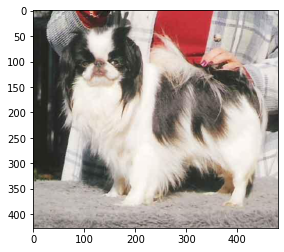

In [206]:
plt.imshow(tf.image.crop_and_resize(plt.imread(img), boxes, box_indices, CROP_SIZE))